In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, f_idx=None, thres=None, left=None, right=None, inf=None, val=None):
        self.feature_index =f_idx
        self.threshold = thres
        self.left = left
        self.right = right
        self.info_gain = inf
        self.value = val

class DecisionTree:
    
    def __init__(self, min_split_samples=2, max_tree_depth=100):
        self.min_split_samples=min_split_samples
        self.max_tree_depth=max_tree_depth
        self.tree_root = None
   
    # funkcije za predvidjanje
    def predict_examples(self, X):
        results = []
        for i in range(X.shape[0]):
            results.append(self.predict(self.tree_root, X.iloc[i]))
        return results

        
    def predict(self, node, x):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self.predict(node.left, x)
        else:
            return self.predict(node.right, x)
        
    
    # funkcije za treniranje
    def train(self, X, y):
        self.tree_root = self.building_decision_tree(X, y)

    
    # funkcija koja gradi stablo odluke
    def building_decision_tree(self, x, y, depth=0):
        
        if(depth >= self.max_tree_depth or y.nunique() == 1 or x.shape[0] < self.min_split_samples):
            # kreirati cvor
            val = self.most_common_label(y)
            return Node(val=val)
        
        best_split = self.find_best_split(x, y)
        left_dataset = pd.DataFrame()
        left_labels = []
        right_dataset = pd.DataFrame()
        right_labels = []
        for index, row in x.iterrows():
            if (row[best_split['column']] <= best_split['threshold']):
                left_dataset = pd.concat([left_dataset, pd.DataFrame(row).T], ignore_index=True)
                left_labels.append(y[index])
            else:
                right_dataset = pd.concat([right_dataset, pd.DataFrame(row).T], ignore_index=True)
                right_labels.append(y[index])
                
        left_labels = pd.Series(left_labels)
        right_labels = pd.Series(right_labels)
        left_tree = self.building_decision_tree(left_dataset, left_labels, depth+1)
        right_tree = self.building_decision_tree(right_dataset, right_labels, depth+1)
        return Node(f_idx=best_split['column'], 
                    thres=best_split['threshold'], 
                    left=left_tree, 
                    right=right_tree)
        
    
    # funckija koja nalazi najbolju podelu
    def find_best_split(self, x, y):
        features_entropies = self.calculate_features_entropies(x, y)
        best_split = None
        best_split_value = float('inf')
        
        for column in x.columns:
            value = features_entropies[column][0]
            if value < best_split_value:
                best_split = {}
                best_split["column"] = column
                best_split["entropy"] = features_entropies[column][0]
                best_split["threshold"]= features_entropies[column][1]
                best_split_value = value
        return best_split
    
    # funkcija koja za svaki feature racuna entropy
    def calculate_features_entropies(self, x, y):
        features_entropies = {}
        
        # za svaki feature pozovi funkciju koja racuna entropy za taj feature
        features = x.columns
        for feature in features:
            feature_entropy, threshold = self.feature_entropy(x, y, feature)
            features_entropies[feature] = feature_entropy, threshold
            
        return features_entropies
    
    # funkcija koja racuna entropy za jedan feature, za sve threshold-ove
    def feature_entropy(self, x, y, feature_idx):
        feature_entropy = float('inf')
        threshold = None
        
        unique_values = pd.Series.unique(x[feature_idx])
        for value in unique_values:
            threshold_entropy = self.threshold_entropy(x, y, feature_idx, value)
            if threshold_entropy < feature_entropy:
                feature_entropy = threshold_entropy
                threshold = value
        return feature_entropy, threshold
    
    # funkcija koja racuna entropy za jedan feature, za jedan threshold
    def threshold_entropy(self, x, y, feature_idx, threshold):
        x_left = []
        y_left = []
        x_right = []
        y_right = []
        
        for idx, value in enumerate(x[feature_idx]):
            if value <= threshold:
                x_left.append(x.iloc[idx])
                y_left.append(y[idx])
            else: 
                x_right.append(x.iloc[idx])
                y_right.append(y[idx])
                
        entropy_left = self.child_dataset_entropy(y_left)
        entropy_right = self.child_dataset_entropy(y_right)
        total_entropy = (len(y_left)/len(y))*entropy_left + (len(y_right)/len(y))*entropy_right
        return total_entropy
    
    # funkcija koja racuna entropy za jedan child dataset
    def child_dataset_entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        proportion = counts / np.sum(counts)
        entropy = - np.sum(proportion*np.log2(proportion))
        return entropy
    
    def most_common_label(self, y):
        counts = y.value_counts()
        most_common_label = counts.idxmax()
        return most_common_label 
    
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)   

In [3]:
col_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "Outcome",
]

df = pd.read_csv("diabetes.csv", skiprows=1, header=None, names=col_names)

In [5]:
df.shape

(768, 9)

In [4]:
# Handle duplicates
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (0, 9)


In [6]:
# Checking null values
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [8]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

# Reset indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

clf = DecisionTree()
clf.train(X_train, y_train)
predictions = clf.predict_examples(X_test)

In [9]:
acc = accuracy(y_test, predictions)
print(acc)

0.6948051948051948


In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        99
           1       0.56      0.65      0.61        55

    accuracy                           0.69       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.71      0.69      0.70       154



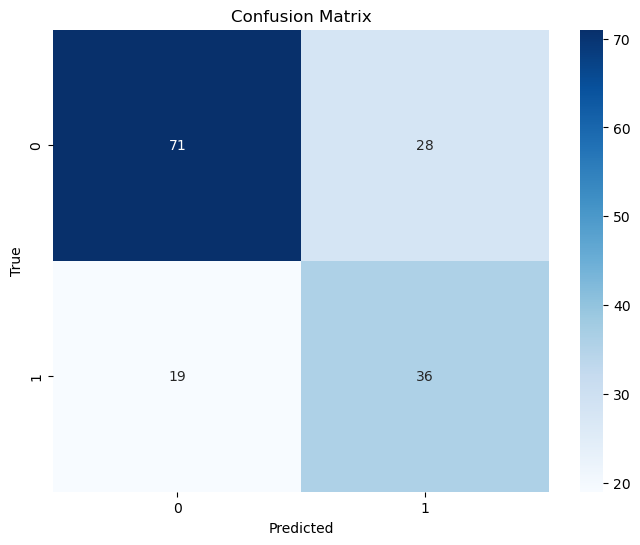

In [15]:
# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()